In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_base_series(length, freq=52):
    """Base series with trend, seasonality and noise"""
    t = np.arange(length)
    trend = 0.1 * t
    seasonality = 5 * np.sin(2 * np.pi * t / freq)
    noise = np.random.normal(0, 1, length)
    return trend + seasonality + noise

def inject_drift(data, drift_type, start_idx, duration, magnitude):
    """Inject concept drift of specified type"""
    affected = data.copy()
    end_idx = start_idx + duration
    
    if drift_type == 'sudden':
        affected[start_idx:] += magnitude
    elif drift_type == 'gradual':
        ramp = np.linspace(0, magnitude, duration)
        affected[start_idx:end_idx] += ramp
        affected[end_idx:] += magnitude
    elif drift_type == 'reoccurring':
        cycle = magnitude * np.sin(2 * np.pi * np.arange(len(affected)) / 26)
        affected[start_idx:] += cycle[start_idx:]
    elif drift_type == 'variance':
        affected[start_idx:] += np.random.normal(0, magnitude, len(affected)-start_idx)
    
    return affected

dates = pd.date_range('1990-01-01', '2015-12-31', freq='W-MON')
length = len(dates)


np.random.seed(42)
data = {
    'var1': inject_drift(
        inject_drift(generate_base_series(length), 
                    'gradual', 520, 260, 3),
        'sudden', 780, 1, 5),
    
    'var2': inject_drift(
        generate_base_series(length), 
        'reoccurring', 260, 1040, 4),
    
    'var3': inject_drift(
        inject_drift(generate_base_series(length), 
                    'variance', 390, 1, 2),
        'variance', 910, 1, 4),

    'var4': inject_drift(
        inject_drift(generate_base_series(length), 
                    'gradual', 650, 130, -3),
        'gradual', 1040, 260, 2),
    
    'var5': inject_drift(
        generate_base_series(length), 
        'sudden', 1170, 1, 6)
}


df = pd.DataFrame(data, index=dates)

# Add ground truth labels
df['drift_period'] = 0
drift_windows = [(300, 400), (500, 600), (700, 900), (1000, 1300)]
for start, end in drift_windows:
    df.iloc[start:end, df.columns.get_loc('drift_period')] = 1

# Save to CSV
df.to_csv('synthetic_multivariate_drift.csv')


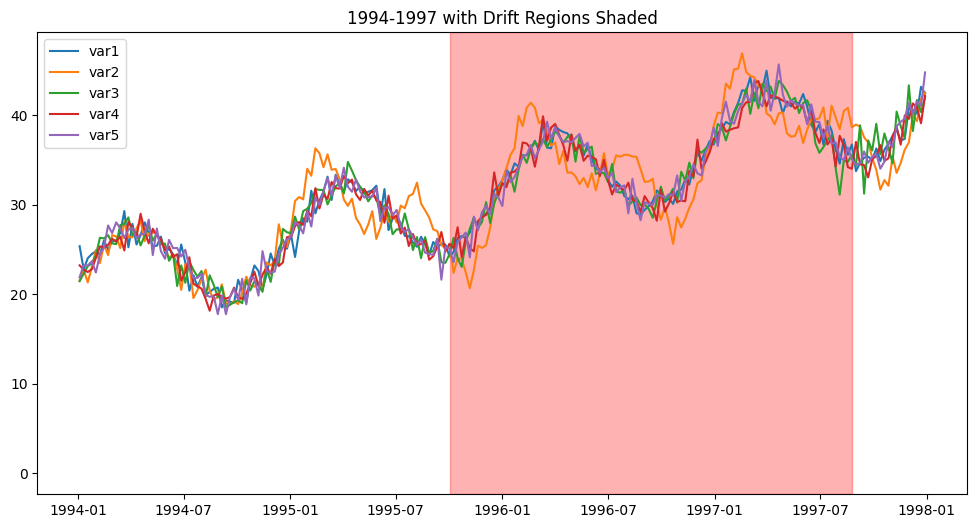

In [19]:
import matplotlib.pyplot as plt

def plot_drift_snippet(df, start_year, end_year):
    mask = (df.index.year >= start_year) & (df.index.year <= end_year)
    plt.figure(figsize=(12,6))
    for col in df.columns[:-1]:
        plt.plot(df[mask].index, df[mask][col], label=col)
    plt.fill_between(df[mask].index, 0, 1, 
                    where=df[mask]['drift_period']==1,
                    color='red', alpha=0.3, transform=plt.gca().get_xaxis_transform())
    plt.title(f'{start_year}-{end_year} with Drift Regions Shaded')
    plt.legend()
    plt.show()

plot_drift_snippet(df, 1994, 1997)  # Example visualization


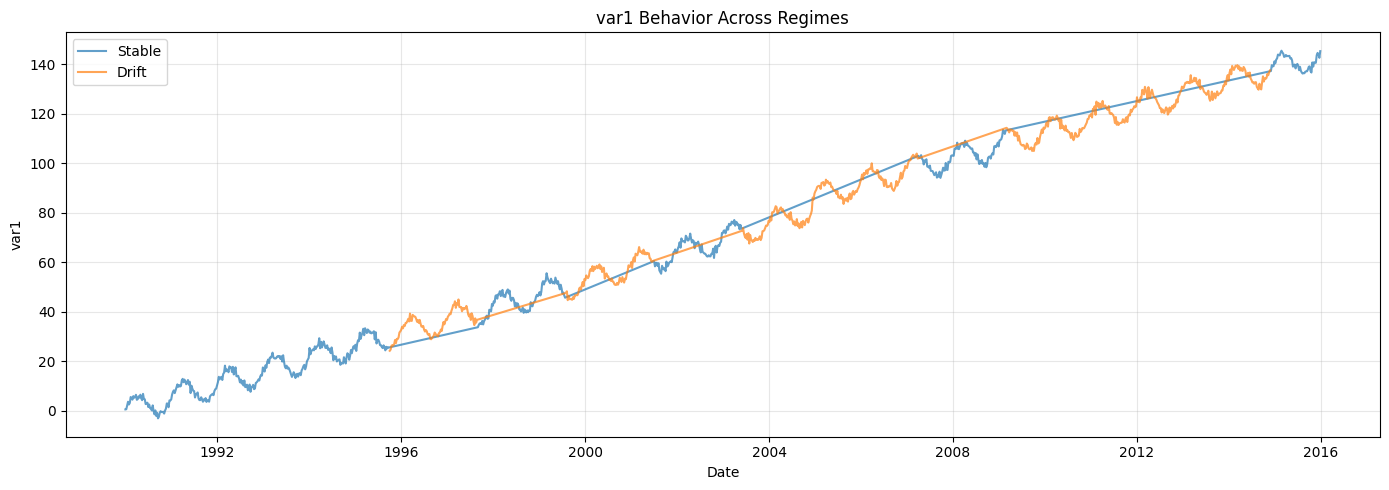

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

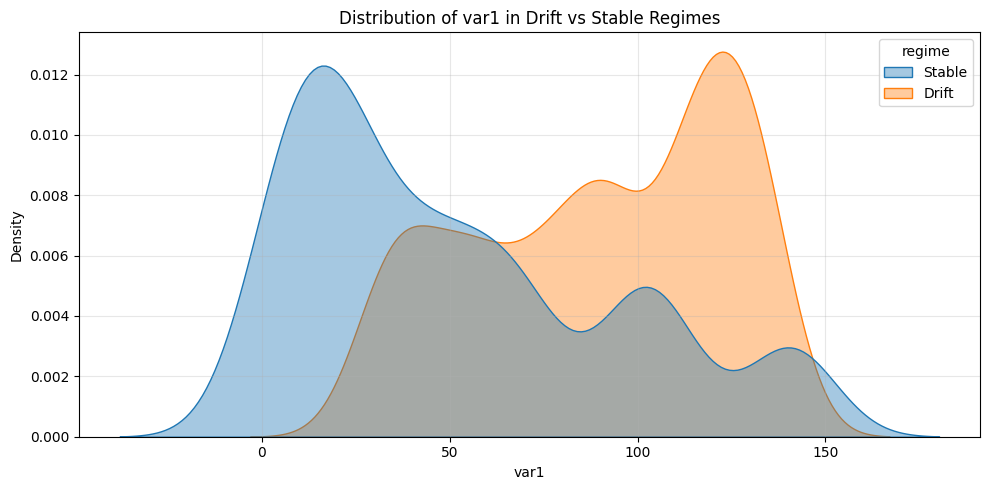

        count       mean        std        min        25%        50%  \
regime                                                                 
Drift   700.0  90.120347  33.788922  24.207461  59.821026  92.936811   
Stable  657.0  51.713125  42.340881  -3.114379  16.656256  41.627862   

               75%         max  
regime                          
Drift   120.388555  139.702300  
Stable   75.280356  145.553752  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('../Data/SynData.csv', parse_dates=['date'])
df = df.dropna(subset=['var1', 'drift_period'])

# Group data into two categories
df['regime'] = df['drift_period'].apply(lambda x: 'Drift' if x == 1 else 'Stable')

# === Plot 1: Time series colored by regime ===
plt.figure(figsize=(14, 5))
for regime in ['Stable', 'Drift']:
    regime_data = df[df['regime'] == regime]
    plt.plot(regime_data['date'], regime_data['var1'], label=regime, alpha=0.7)

plt.title('var1 Behavior Across Regimes')
plt.xlabel('Date')
plt.ylabel('var1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Plot 2: Distribution of var1 by regime ===
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='var1', hue='regime', fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of var1 in Drift vs Stable Regimes')
plt.xlabel('var1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Summary Statistics ===
print(df.groupby('regime')['var1'].describe())


In [2]:
# Basic stats
summary = df.groupby('regime')['var1'].describe()
print(summary)

# Check variance differences
stable_var = df[df['regime'] == 'Stable']['var1'].var()
drift_var = df[df['regime'] == 'Drift']['var1'].var()
print(f"\nStable Variance: {stable_var:.3f}")
print(f"Drift Variance: {drift_var:.3f}")


        count       mean        std        min        25%        50%  \
regime                                                                 
Drift   700.0  90.120347  33.788922  24.207461  59.821026  92.936811   
Stable  657.0  51.713125  42.340881  -3.114379  16.656256  41.627862   

               75%         max  
regime                          
Drift   120.388555  139.702300  
Stable   75.280356  145.553752  

Stable Variance: 1792.750
Drift Variance: 1141.691


In [3]:
for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    print(f"\n=== {var} ===")
    print(df.groupby('regime')[var].describe())



=== var1 ===
        count       mean        std        min        25%        50%  \
regime                                                                 
Drift   700.0  90.120347  33.788922  24.207461  59.821026  92.936811   
Stable  657.0  51.713125  42.340881  -3.114379  16.656256  41.627862   

               75%         max  
regime                          
Drift   120.388555  139.702300  
Stable   75.280356  145.553752  

=== var2 ===
        count       mean        std        min        25%        50%  \
regime                                                                 
Drift   700.0  84.889959  30.635821  20.664756  59.344134  85.500971   
Stable  657.0  49.697035  39.405884  -2.447126  16.220003  41.849629   

               75%         max  
regime                          
Drift   112.538777  134.018010  
Stable   73.900207  140.425379  

=== var3 ===
        count       mean        std        min        25%        50%  \
regime                                      

In [4]:
import numpy as np
import pandas as pd

def generate_base_series(length, freq=52, trend_slope=0.1, noise_std=1.0):
    """Base series with trend, seasonality, and noise."""
    t = np.arange(length)
    trend = trend_slope * t
    seasonality = 5 * np.sin(2 * np.pi * t / freq)
    noise = np.random.normal(0, noise_std, length)
    return trend + seasonality + noise

def inject_drift(data, drift_type, start_idx, duration, magnitude):
    """Inject concept drift of specified type."""
    affected = data.copy()
    end_idx = start_idx + duration

    if drift_type == 'sudden':
        affected[start_idx:] += magnitude
    elif drift_type == 'gradual':
        ramp = np.linspace(0, magnitude, duration)
        affected[start_idx:end_idx] += ramp
        affected[end_idx:] += magnitude
    elif drift_type == 'reoccurring':
        cycle = magnitude * np.sin(2 * np.pi * np.arange(len(affected)) / 26)
        affected[start_idx:] += cycle[start_idx:]
    elif drift_type == 'variance':
        affected[start_idx:] += np.random.normal(0, magnitude, len(affected)-start_idx)
    elif drift_type == 'concept_flip':
        affected[start_idx:end_idx] = -affected[start_idx:end_idx] + 2 * np.mean(affected[:start_idx])
    
    return affected

# === Time Index ===
dates = pd.date_range('1990-01-01', '2015-12-31', freq='W-MON')
length = len(dates)

np.random.seed(42)

# === Multivariate Series with Drift Injection ===
data = {
    'var1': inject_drift(
        inject_drift(generate_base_series(length, trend_slope=0.02), 'gradual', 400, 200, 10),
        'sudden', 900, 1, -15
    ),
    'var2': inject_drift(
        inject_drift(generate_base_series(length), 'reoccurring', 520, 520, 8),
        'variance', 1100, 1, 6
    ),
    'var3': inject_drift(
        inject_drift(generate_base_series(length, noise_std=0.5), 'concept_flip', 650, 150, 0),
        'gradual', 900, 100, 5
    ),
    'var4': inject_drift(
        inject_drift(generate_base_series(length, noise_std=3.0), 'variance', 300, 1, 8),
        'sudden', 1100, 1, 10
    ),
    'var5': inject_drift(
        generate_base_series(length, freq=13), 'gradual', 1000, 150, -8
    )
}

df = pd.DataFrame(data, index=dates)

# === Drift Labeling ===
df['drift_period'] = 0
drift_windows = [(250, 450), (620, 720), (890, 950), (1050, 1200)]
for start, end in drift_windows:
    df.iloc[start:end, df.columns.get_loc('drift_period')] = 1

# === Save Output ===
df.to_csv('synthetic_multivariate_drift_v2.csv')
print("✅ Synthetic data saved to 'synthetic_multivariate_drift_v2.csv'")


✅ Synthetic data saved to 'synthetic_multivariate_drift_v2.csv'


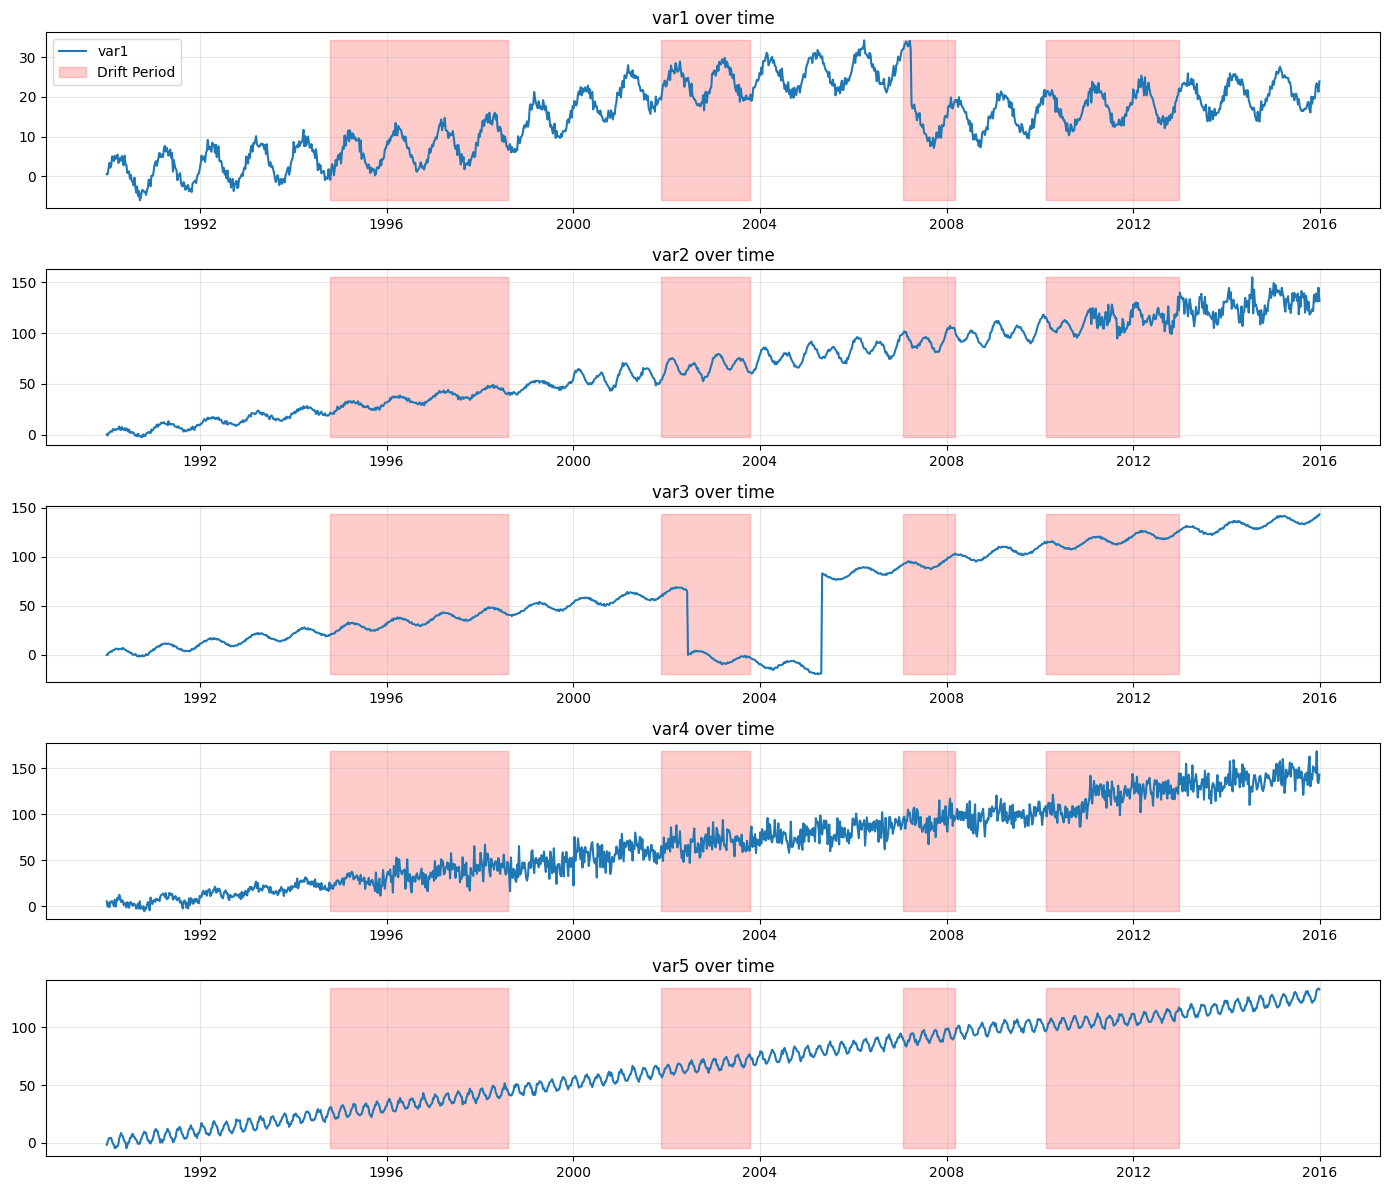

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

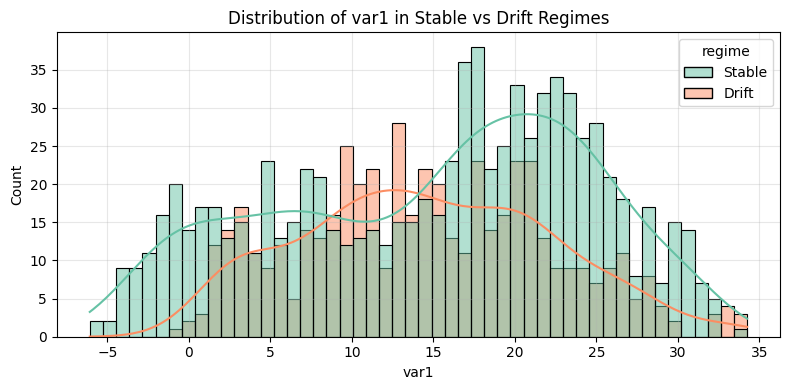

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

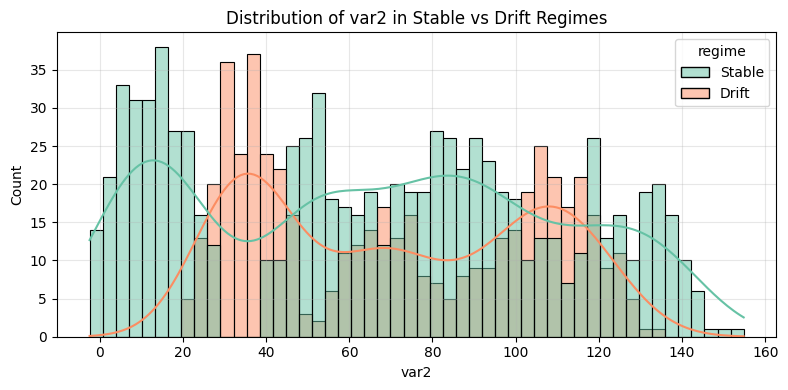

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

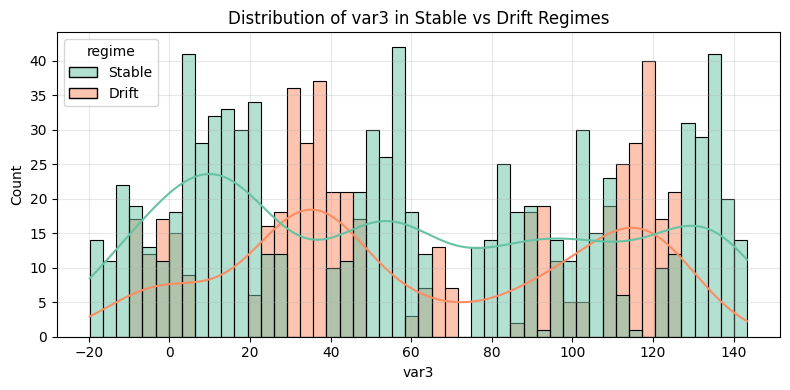

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

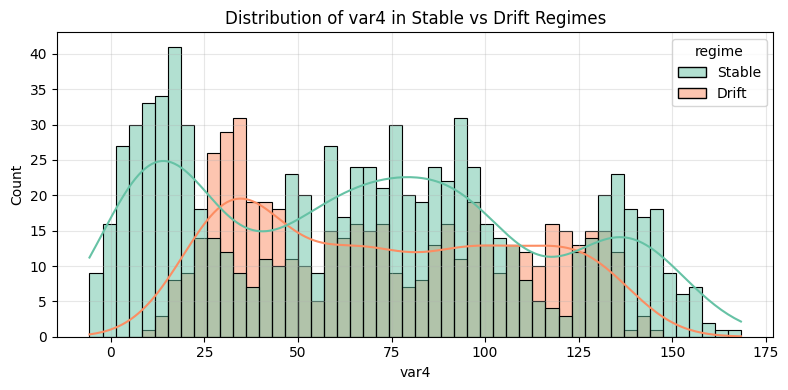

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

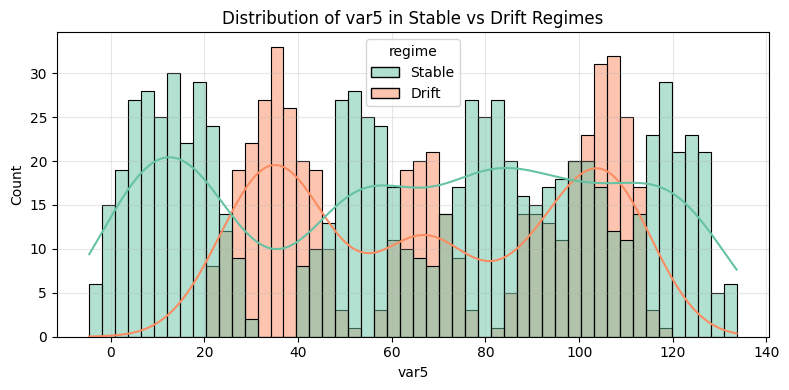

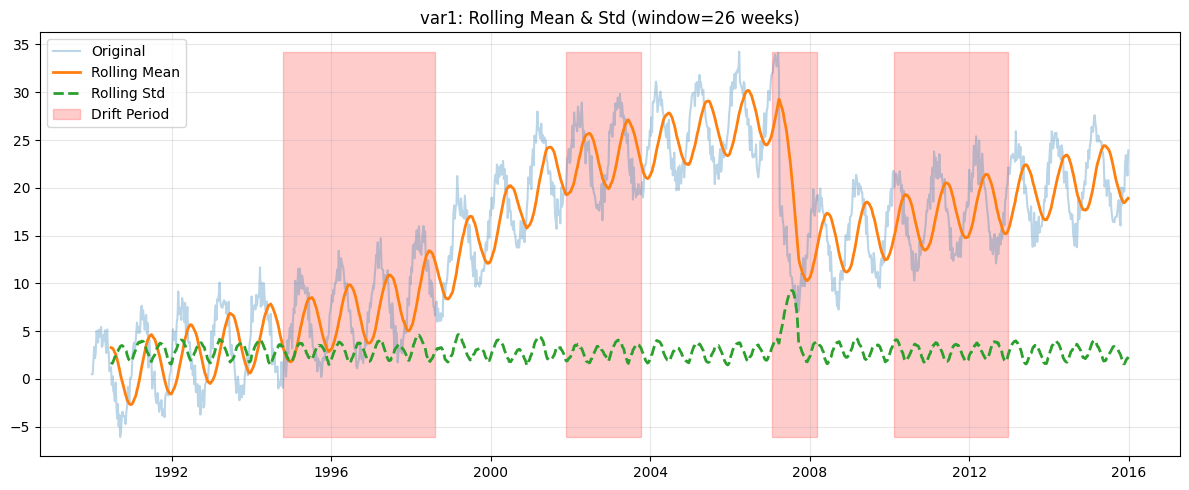

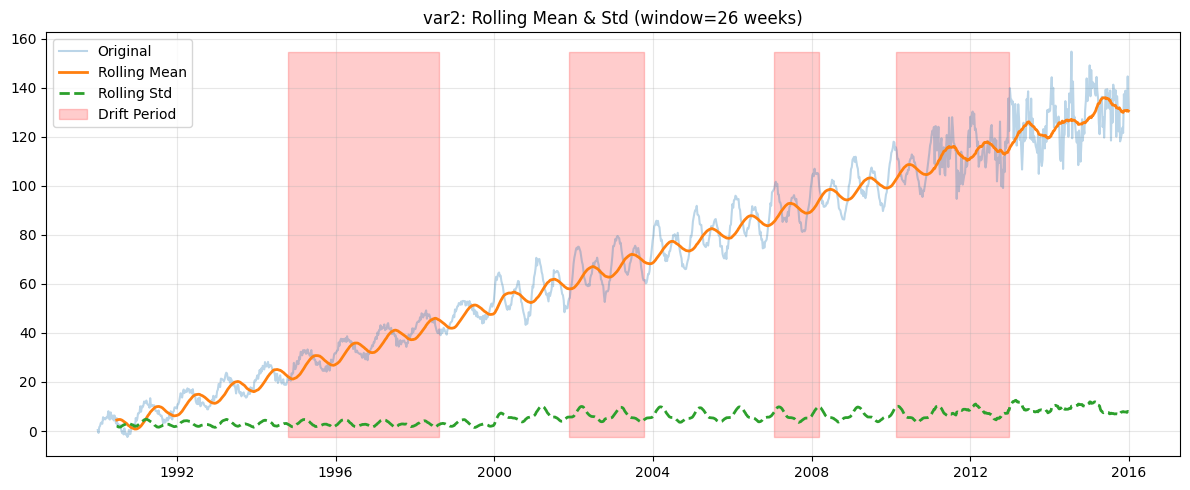

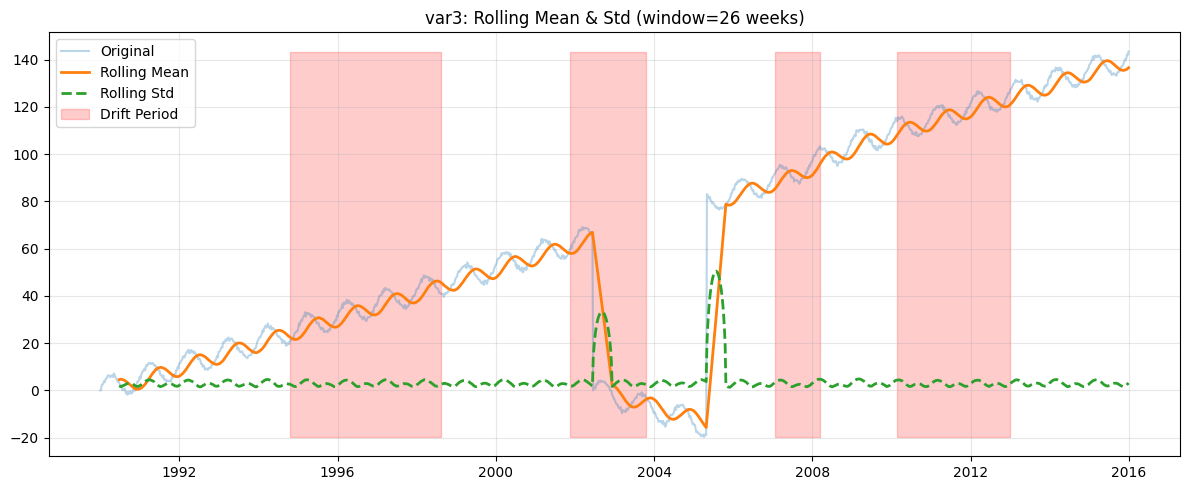

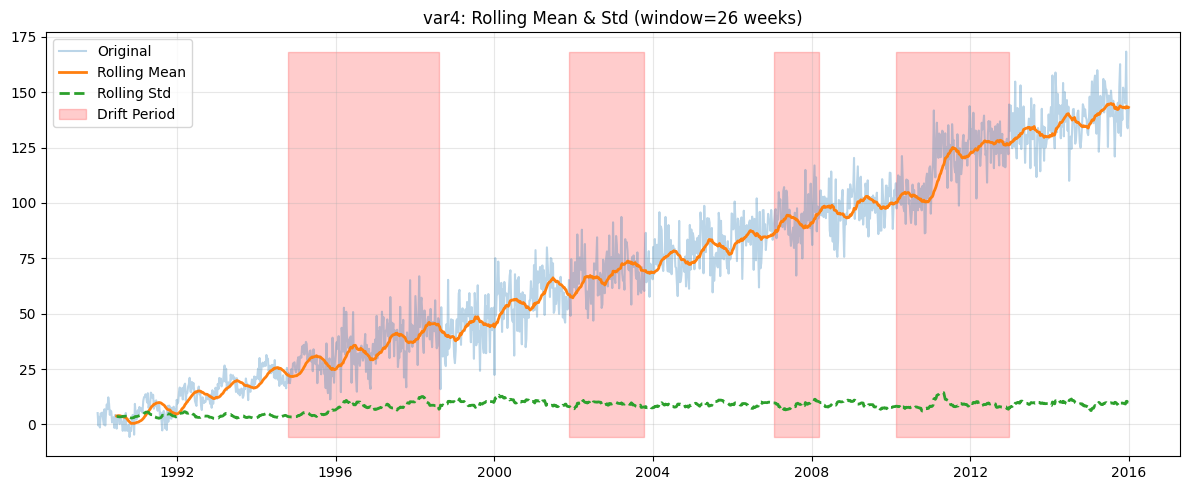

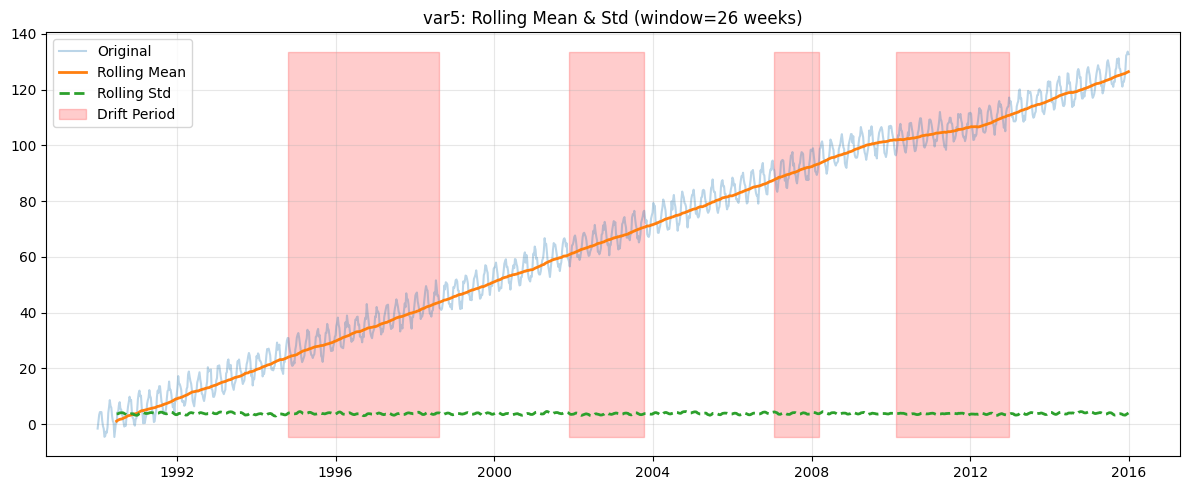

         var1                                                 var2         \
        count   mean   std   min   25%    50%    75%    max  count   mean   
regime                                                                      
Drift   510.0  14.63  7.65 -0.94  9.13  14.28  20.31  34.13  510.0  70.96   
Stable  847.0  15.00  9.64 -6.07  7.09  16.98  22.70  34.25  847.0  65.95   

        ...    var4           var5                                             \
        ...     75%     max  count   mean    std    min    25%    50%     75%   
regime  ...                                                                     
Drift   ...  105.36  144.47  510.0  68.87  30.87  20.92  38.08  67.53  101.36   
Stable  ...   98.68  168.36  847.0  64.51  40.44  -4.60  21.38  68.12   99.10   

                
           max  
regime          
Drift   117.15  
Stable  133.63  

[2 rows x 40 columns]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the generated data ===
df = pd.read_csv("../Data/simulateddata.csv", parse_dates=['date'], index_col='date')

# === Convert drift_period to categorical for clarity ===
df['regime'] = df['drift_period'].map({0: 'Stable', 1: 'Drift'})

# === 1. Time series plots of all variables with drift overlay ===
plt.figure(figsize=(14, 12))
for i, var in enumerate(['var1', 'var2', 'var3', 'var4', 'var5']):
    plt.subplot(5, 1, i+1)
    plt.plot(df.index, df[var], label=var)
    plt.fill_between(df.index, df[var].min(), df[var].max(),
                     where=df['drift_period'] == 1, color='red', alpha=0.2, label='Drift Period' if i==0 else "")
    plt.title(f"{var} over time")
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# === 2. Distribution plots of each variable across regimes ===
for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=var, hue='regime', kde=True, bins=50, palette='Set2')
    plt.title(f"Distribution of {var} in Stable vs Drift Regimes")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === 3. Rolling mean and std (window=26 weeks) for each variable ===
window = 26
for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    rolling_mean = df[var].rolling(window).mean()
    rolling_std = df[var].rolling(window).std()

    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df[var], alpha=0.3, label='Original')
    plt.plot(df.index, rolling_mean, label='Rolling Mean', linewidth=2)
    plt.plot(df.index, rolling_std, label='Rolling Std', linestyle='--', linewidth=2)
    plt.fill_between(df.index, df[var].min(), df[var].max(),
                     where=df['drift_period'] == 1, color='red', alpha=0.2, label='Drift Period')
    plt.title(f"{var}: Rolling Mean & Std (window={window} weeks)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 4. Summary statistics by regime ===
summary = df.groupby('regime')[['var1', 'var2', 'var3', 'var4', 'var5']].describe().round(2)
print(summary)


In [8]:
df[df['drift_period'] == 1].index.min(), df[df['drift_period'] == 1].index.max()
df['drift_block'] = (df['drift_period'].diff() != 0).cumsum()
drift_ranges = df[df['drift_period'] == 1].groupby('drift_block').apply(lambda x: (x.index[0], x.index[-1]))
print(drift_ranges)


drift_block
2    (1994-10-17 00:00:00, 1998-08-10 00:00:00)
4    (2001-11-19 00:00:00, 2003-10-13 00:00:00)
6    (2007-01-22 00:00:00, 2008-03-10 00:00:00)
8    (2010-02-15 00:00:00, 2012-12-24 00:00:00)
dtype: object


/var/tmp/ipykernel_19759/277588951.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drift_ranges = df[df['drift_period'] == 1].groupby('drift_block').apply(lambda x: (x.index[0], x.index[-1]))


In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../Data/simulateddata.csv", parse_dates=['date'], index_col='date')

# Create a unique ID for each continuous regime
df['regime_block'] = (df['drift_period'] != df['drift_period'].shift()).cumsum()

# Group by regime type and block
regime_blocks = df.groupby(['drift_period', 'regime_block']).apply(
    lambda x: (x.index[0], x.index[-1])
)

# Rename for clarity
regime_blocks = regime_blocks.reset_index(level=1, drop=True).rename("date_range")
print(regime_blocks)


drift_period
0    (1990-01-01 00:00:00, 1994-10-10 00:00:00)
0    (1998-08-17 00:00:00, 2001-11-12 00:00:00)
0    (2003-10-20 00:00:00, 2007-01-15 00:00:00)
0    (2008-03-17 00:00:00, 2010-02-08 00:00:00)
0    (2012-12-31 00:00:00, 2015-12-28 00:00:00)
1    (1994-10-17 00:00:00, 1998-08-10 00:00:00)
1    (2001-11-19 00:00:00, 2003-10-13 00:00:00)
1    (2007-01-22 00:00:00, 2008-03-10 00:00:00)
1    (2010-02-15 00:00:00, 2012-12-24 00:00:00)
Name: date_range, dtype: object


/var/tmp/ipykernel_19759/1932797142.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regime_blocks = df.groupby(['drift_period', 'regime_block']).apply(
